In [1]:
%%capture
!pip install transformers datasets soundfile speechbrain accelerate

In [25]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import datasets
from datasets import load_dataset

dataset = load_dataset('Cets/audio-logs-vn-1')
dataset['train'].features

train-00000-of-00002.parquet:   0%|          | 0.00/342M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/345M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/173M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1913 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/479 [00:00<?, ? examples/s]

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'text': Value(dtype='string', id=None)}

# Special characters

In [4]:
from transformers import SpeechT5ForTextToSpeech, SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)
tokenizer = processor.tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [5]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text.lower()))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names['train'],
)

dataset_vocab = set(vocabs['train']["vocab"][0] + vocabs['test']['vocab'][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}
new_tokens = list(dataset_vocab - tokenizer_vocab)
print(new_tokens)

Map:   0%|          | 0/1913 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

['ố', 'ã', 'ể', 'ế', '+', '%', 'ệ', '=', 'ờ', 'ộ', 'ủ', 'ú', 'ử', 'ư', 'ă', 'ẵ', '“', '”', 'ẩ', 'ẫ', 'đ', 'ẹ', 'ở', 'ò', 'ổ', 'ỉ', '5', 'í', 'ũ', 'ù', 'ω', 'ấ', 'ụ', 'ễ', 'ầ', ' ', '>', 'ữ', '°', '²', 'ẳ', '7', 'ứ', 'ẽ', 'ề', 'ó', 'µ', '0', 'ỡ', 'ợ', 'ị', 'ặ', 'ỹ', 'ỳ', 'è', 'ạ', '±', 'ả', '4', 'ồ', 'ằ', 'á', 'ắ', 'ự', 'ỷ', 'ỵ', '1', 'ý', '8', 'ô', 'ậ', 'ớ', 'à', 'ĩ', 'ö', 'â', 'ẻ', '6', 'ỗ', 'õ', 'ì', 'ọ', '9', 'ỏ', '2', 'ơ', 'ừ', '3', '’', '³']


In [6]:
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(171, 768, padding_idx=1)

# Speaker embedding

*! We use a X-vector model for english now, it is possible to train a new X-vector model*

In [7]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

<ipython-input-7-f28baad2ea60>:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [8]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["text"].lower(),
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

['input_ids', 'labels', 'speaker_embeddings']
(512,)


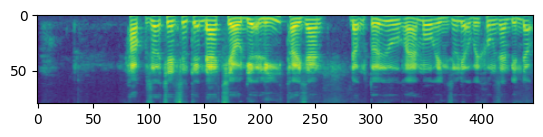

In [16]:
processed_example = prepare_dataset(dataset['train'][0])
print(list(processed_example.keys()))
print(processed_example["speaker_embeddings"].shape)
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [17]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names['train'])

Map:   0%|          | 0/1913 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

# Data collator

In [21]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

data_collator = TTSDataCollatorWithPadding(processor=processor)

# Train

In [22]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [24]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speechT5-vn-1",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=25,
    eval_steps=25,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [27]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    processing_class=processor,
)

In [28]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 